# 🧩  01. cleaning

## 1.0 Load and Import

In [8]:
import sys
import os
import pandas as pd

In [9]:
sys.path.append("src")
    
import cleaning_01 as clean
import save as sv
import ploting as pl

In [10]:
source = "../data/raw/dataset.csv"
dataBase = pd.read_csv(source)

# avoid unwanted changes to our source
df = dataBase.copy()

In [11]:
df.head(1)

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Engineering,52.29,55.03,57.82,...,85.9,56.09,F,6.2,No,Yes,High School,Medium,5,4.7


### Basic integrity test

In [12]:
# We make a Basic check to see if what we have, is what we expect. (columns)
clean.check_required_columns(df)

✅ All required columns are present.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              4484 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             4483 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

This check verifies that all data types seem accurate and helps catch potential issues before the EDA 

### B. Missing values

#### B.0 Overview

In [14]:
clean.get_missing_percentage(df)

📊 Percentage of missing values:


Attendance (%)            10.32
Assignments_Avg           10.34
Parent_Education_Level    35.88
dtype: float64

In [15]:
print(df['Parent_Education_Level'].unique())

['High School' nan "Master's" 'PhD' "Bachelor's"]


---
#### B.1 Parent_Education_Level

With over a third of the entries missing, simply imputing a default or common value could introduce significant bias, as it may not accurately represent the variability in the data.

In situations like this, we have to consider a few approaches:

- Retaining Missing Values: Some statistical methods can handle missing data directly, so leaving the values as NaN might be appropriate.
- Dropping the Column: If the variable is not crucial to the analysis, removing it can prevent potential distortions.
- Inputing missing data with Unknown

I will aproach with the input method since categorizing these values as "Unknown" can help retain hidden patterns, and handle the missing values. \
Additionally, this approach ensures consistency for machine learning models, many of which struggle with NaN values. 

##### B.1.0 Iputation Method

In [16]:
df['Parent_Education_Level'] = df['Parent_Education_Level'].fillna('Unknown')

In [17]:
print("Missing Count of Parent_Education_Level:\n", df[['Parent_Education_Level']].isnull().sum())

Missing Count of Parent_Education_Level:
 Parent_Education_Level    0
dtype: int64


##### B.1.1 Conclusion

The NaN/Null values from Parent_Education_Level have become the string/object Unknown
> **`NaN/Null` To `Unknown`**

---
#### B.2 Assignments_Avg AND Attendance

Assignments_Avg and Attendance have over 10% missing.

In Initial attempts using median or mean caused an artificial peak,
distorting the original data distribution. Additionally, Assignments_Avg
shows low linear or monotonic correlation with other features, making
regression or KNN methods less reliable.

Thus, Random Sampling Imputation was chosen becase:
 - Preserves the original distribution.
 - Does not rely on correlations.
 - Prevents artificial spikes caused by repeated median or mean.

Now let's prove that this is a sound method for our data.  
First, we will analise the distribuition:

##### B.2.0 Proof

In [18]:
numerical_cols = ['Attendance (%)','Assignments_Avg']
plot_histograms(df, numerical_cols)

print("percentage and distribution plots.")

NameError: name 'plot_histograms' is not defined

The Assignments_Avg and Attendance columns show a relatively symmetric distribution, without significant skewness.
This symmetry is essential because it implies that randomly sampling existing (non-missing) data points are less likely to introduce bias.

With the mean and median we can streghen this assumption:

In [ ]:
summary_df = df[['Assignments_Avg', 'Attendance (%)']].agg(['mean', 'median']).rename(index={'mean': 'Mean', 'median': 'Median'})
print(summary_df)

        Assignments_Avg  Attendance (%)
Mean          74.798673       75.431409
Median        74.810000       75.725000


> We confirmed that indeed they have a symmetric distribution, indicated by the close alignment between their means and medians.

Therefore we can also  that columns have relativily low variance, meaning the observed values are closely grouped together. With low variance, random sampling does not introduce extreme values or distortions, preserving the natural variability of the data.

##### B.2.1 Inputation Method of Random Sampling

In [ ]:
df_random = df.copy()
df_original = df

columns_to_impute = ['Assignments_Avg', 'Attendance (%)']
df_random = apply_random_imputation(df_random, columns_to_impute)

print("Missing values after imputation:\n", df_random[['Assignments_Avg', 'Attendance (%)']].isnull().sum())

Missing values after imputation:
 Assignments_Avg    0
Attendance (%)     0
dtype: int64


##### B.2.3 Visual Confirmation and KS TEST

###### A. Attendance (%)

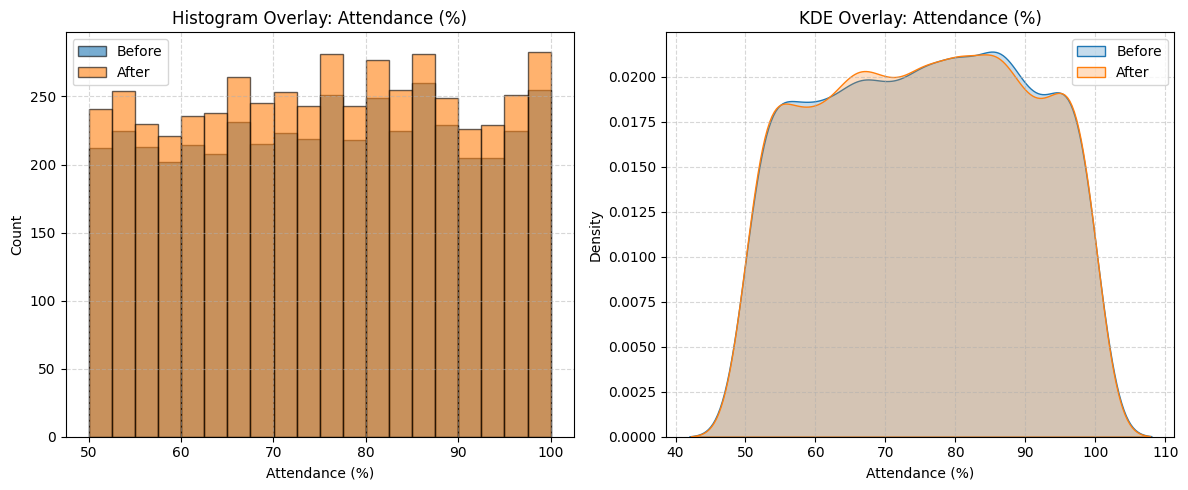

A Overlay of Before the Random Sampling Inputation Method and After
KS Test for Attendance (%): KS Statistic=0.0043, p-value=1.0000



In [ ]:
plot_overlay_histogram_kde(df_original, df_random, 'Attendance (%)')
print("A Overlay of Before the Random Sampling Inputation Method and After")
# KS Test for 'Attendance (%)'
ks_test_imputation(df_original, df_random, 'Attendance (%)')

###### B. Assignments_Avg

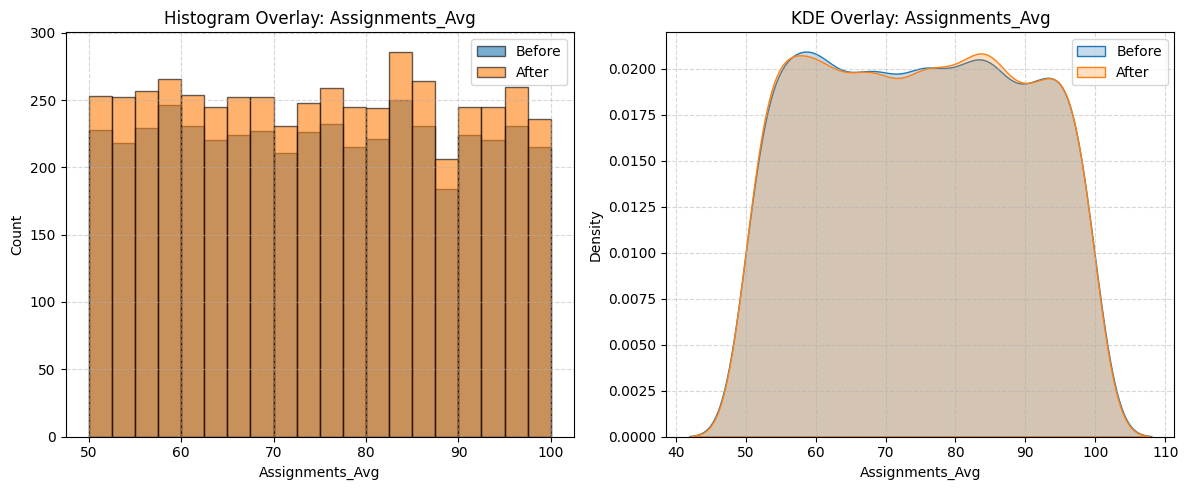

A Overlay of Before the Random Sampling Inputation Method and After
KS Test for Assignments_Avg: KS Statistic=0.0027, p-value=1.0000



In [ ]:
plot_overlay_histogram_kde(df_original, df_random, 'Assignments_Avg')
print("A Overlay of Before the Random Sampling Inputation Method and After")
# KS Test for 'Assignments_Avg'
ks_test_imputation(df_original, df_random, 'Assignments_Avg')

In [ ]:
# apply the changes to our main flow
df = df_random

##### B.2.5 Conclusion

With the Visual Overlaw and use of the **Kolmogorov-Smirnov (KS) test**, we are certain that:

> **Our imputation has not altered the underlying distributions of these variables, which is a positive outcome for preserving data integrity during the imputation process.**

**What is the KS test?** \
In simpler terms:

**1\. KS Statistic:** Indicates if the distributions are similar.  
- **Lower = Better**
  - 0.00 - 0.05: **Excellent match 
  **
  - 0.05 - 0.10: **Good match ✔️**
  - 0.10 - 0.20: Medium difference ⚠️
  - 0.20 - 0.30: Poor match ❌
  - 0.30: Very poor match 🚩

**2\. P-value:** How statistically significant is the difference between the distributions before and after imputation.  
- **Lower = Worse**
  - value < 0.05: Really bad ❌ (significant difference)
  - value ≥ 0.05: Good ✅ (no significant difference)

**Thus:**  
- Attendance (%): **KS Statistic = 0.0043**  
- Assignments_Avg: **KS Statistic = 0.0027**

Both statistics show a **very small difference and an excellent match**.

Additionally, a **p-value equal to 1** is very strong evidence that **no statistically significant difference** is present.

### C. Range

Check if everthing is in range.

In [ ]:
# validate Range Score of Numerical Columns and Grades
validate_data(df)

 ✅ Success - Not found element out of range  ✔


### D. Duplicate Unique values

Duplicate values in fields that should be unique, can break the integrity of our data. \
In this dataset, two columns stand out:

- Student_ID
- Email

That cannot be duplicated, therefore must be checked.


#### D.0 Checker Student_ID And Email

In [ ]:
columns=['Student_ID', 'Email']

check_duplicates(df, columns)

Student_ID:  ✅ Success - No Duplicated Elements.

Email:  ✅ Success - No Duplicated Elements.



### E. Outlier in Numerical Columns 

A simple checker for outliers in our numerical data.

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns

In [ ]:
detect_outliers_IQR(df, numeric_columns)

 ✅ No outliers in column: Age
 ✅ No outliers in column: Attendance (%)
 ✅ No outliers in column: Midterm_Score
 ✅ No outliers in column: Final_Score
 ✅ No outliers in column: Assignments_Avg
 ✅ No outliers in column: Quizzes_Avg
 ✅ No outliers in column: Participation_Score
 ✅ No outliers in column: Projects_Score
 ✅ No outliers in column: Total_Score
 ✅ No outliers in column: Study_Hours_per_Week
 ✅ No outliers in column: Stress_Level (1-10)
 ✅ No outliers in column: Sleep_Hours_per_Night


### F. Saving Cleaned Data

In [ ]:
save_dataframe(df, '../data/processed', 'student_performance_cleaned_V3.csv')

 ✅ Success - DataFrame saved at: ../data/processed/student_performance_cleaned_V3.csv ✔


# 🔍 A. Overview

### 🔹 Missing Values
- `Attendance (%)` and `Assignments_Avg` had over **10% of missing values**.
- Applied **Random Sampling Imputation**:
  - Preserves original data distribution.
  - Avoids artificial peaks from mean/median.
  - Doesn’t rely on correlations.

### 🔹 Categorical Nulls
- Filled `Parent_Education_Level` with `"Unknown"`:
  - Keeps full dataBase integrity.
  - Retains potential hidden patterns.
  - Avoids issues in ML models that can't handle NaN.

### 🔹 Duplicates Check
- Validated uniqueness of:
  - `Student_ID` ✅
  - `Email` ✅  
- Prevents ID conflicts, data corruption, and communication issues.

### 🔹 Numerical Validation
- Verified score columns fall within valid ranges:
  - Percentages and scores: **0–100**
  - `Participation_Score`: **0–10**
  - `Stress_Level (1–10)`...
- No invalid values detected ✅.

### 🔹 Grade Validation
- Confirmed all grades are within accepted values: **A, B, C, D, F** ✅

### 🔹 Null Check Summary
- Confirmed no remaining NaNs except:
  - `Parent_Education_Level` → filled as `"Unknown"` (Intentional)
  - `Attendance (%)` and `Assignments_Avg` → imputed

### 📁 Output
Cleaned dataset saved for analysis in:

> ../data/processed/student_performance_cleaned_V3.csv